<a href="https://colab.research.google.com/github/vysf/machine-learning-practice/blob/master/Submission_Membuat_Model_NLP_dengan_TensorFlow_(Proyek_1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Collection
Dataset yang digunakan adalah data [Coronavirus tweets NLP - Text Classification](https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification)

In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
train_path = '/content/Corona_NLP_train.csv'
test_path = '/content/Corona_NLP_test.csv'

df_train = pd.read_csv(train_path, encoding="ISO-8859-1")
df_test = pd.read_csv(test_path, encoding="ISO-8859-1")

*   Dataset yang akan dipakai bebas, namun minimal memiliki 1000 sampel.



In [ ]:
lenght_train = df_train.shape[0]
lenght_test = df_test.shape[0]
dataset_amount = lenght_train + lenght_test

print("Jumlah data train:", lenght_train)
print("Jumlah data test:", lenght_test)
print("Total sampel:", dataset_amount)

Jumlah data train: 41157
Jumlah data test: 3798
Total sampel: 44955


## Data Preparation


Menggabungkan kedua dataset untuk membuat rasio baru

In [ ]:
df = pd.concat([df_train, df_test], ignore_index=True)
df.head(10)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,As news of the regionÂs first confirmed COVID...,Positive
6,3805,48757,"35.926541,-78.753267",16-03-2020,Cashier at grocery store was sharing his insig...,Positive
7,3806,48758,Austria,16-03-2020,Was at the supermarket today. Didn't buy toile...,Neutral
8,3807,48759,"Atlanta, GA USA",16-03-2020,Due to COVID-19 our retail store and classroom...,Positive
9,3808,48760,"BHAVNAGAR,GUJRAT",16-03-2020,"For corona prevention,we should stop to buy th...",Negative


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44955 entries, 0 to 44954
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       44955 non-null  int64 
 1   ScreenName     44955 non-null  int64 
 2   Location       35531 non-null  object
 3   TweetAt        44955 non-null  object
 4   OriginalTweet  44955 non-null  object
 5   Sentiment      44955 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.1+ MB




*   Dataset memiliki 3 kelas atau lebih

cek jumlah kelas



In [ ]:
def change_labels(label):
  if label == "Extremely Positive":
    new_label = "Positive"
  elif label == "Extremely Negative":
    new_label = "Negative"
  else:
    new_label = label
  return new_label

df["Sentiment"] = df["Sentiment"].apply(change_labels)

In [ ]:
labels = df["Sentiment"].value_counts()
print("jumlah kelas:", labels.count(), "kelas")
labels

jumlah kelas: 3 kelas


Positive    19592
Negative    17031
Neutral      8332
Name: Sentiment, dtype: int64

<Axes: title={'center': 'Sentiments clasification of each Tweet'}, xlabel='Sentiments', ylabel='Number of Tweets'>

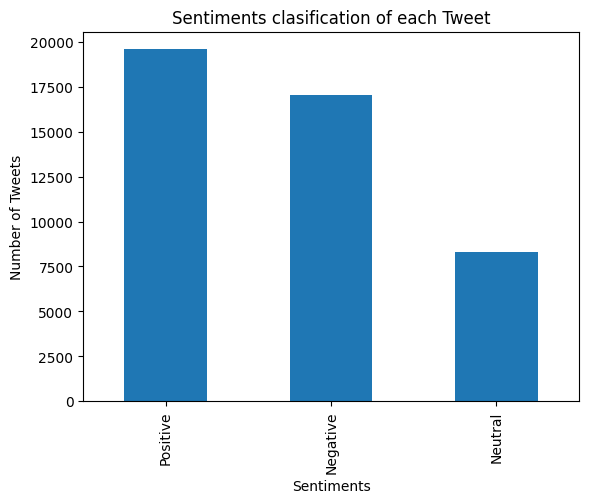

In [ ]:
labels.sort_values(ascending=False).plot(
    kind='bar',
    xlabel='Sentiments',
    ylabel='Number of Tweets',
    title='Sentiments clasification of each Tweet'
)

### Data Cleaning
Hapus kolom yang tidak digunakan

In [ ]:
df = df.drop(columns=["UserName", "ScreenName", "Location", "TweetAt"])
df.head(10)

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Negative
5,As news of the regionÂs first confirmed COVID...,Positive
6,Cashier at grocery store was sharing his insig...,Positive
7,Was at the supermarket today. Didn't buy toile...,Neutral
8,Due to COVID-19 our retail store and classroom...,Positive
9,"For corona prevention,we should stop to buy th...",Negative


Hapus element text yang tidak diperlukan

In [ ]:
# hapus tanda baca
df.OriginalTweet = df.OriginalTweet.str.replace('[^\w\s]','')

# hapus mention
df.OriginalTweet = df.OriginalTweet.str.replace(r'@\w+','')

# hapus special character
df.OriginalTweet = df.OriginalTweet.str.replace('[#,@,&,-,_]', '')

# hapus digit angka
df.OriginalTweet = df.OriginalTweet.str.replace('\d*','')

# hapus link www dan http/https
df.OriginalTweet = df.OriginalTweet.str.replace('w{3}','')
df.OriginalTweet = df.OriginalTweet.str.replace("http\S+", "")

# hapus double space dan ubah jadi single space
df.OriginalTweet = df.OriginalTweet.str.replace('\s+', ' ')

# hapus single character
df.OriginalTweet = df.OriginalTweet.str.replace(r'\s+[a-zA-Z]\s+', '')

# ubah ke lowercase
df.OriginalTweet = df.OriginalTweet.str.lower()

<ipython-input-10-e60be0afbb97>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df.OriginalTweet = df.OriginalTweet.str.replace('[^\w\s]','')
<ipython-input-10-e60be0afbb97>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df.OriginalTweet = df.OriginalTweet.str.replace(r'@\w+','')
<ipython-input-10-e60be0afbb97>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df.OriginalTweet = df.OriginalTweet.str.replace('[#,@,&,-,_]', '')
<ipython-input-10-e60be0afbb97>:11: FutureWarning: The default value of regex will change from True to False in a future version.
  df.OriginalTweet = df.OriginalTweet.str.replace('\d*','')
<ipython-input-10-e60be0afbb97>:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df.OriginalTweet = df.OriginalTweet.str.replace('w{3}','')
<ipython-input-10-e60be0afbb97>:15: F

In [ ]:
df.OriginalTweet.head(10)

0                 menyrbie philgahan chrisitv and and 
1    advice talk to your neighbours family to excha...
2    coronavirus australia woolworths to give elder...
3    my food stock is not the only one which is emp...
4    me ready to go at supermarket during the covid...
5    as news of the regionâs first confirmed covid ...
6    cashier at grocery store was sharing his insig...
7    was at the supermarket today didnt buy toilet ...
8    due to covid our retail store and classroom in...
9    for corona preventionwe should stop to buy thi...
Name: OriginalTweet, dtype: object

Hapus stop word

In [ ]:
stop_words = set(stopwords.words('english'))
df.OriginalTweet = df.OriginalTweet.apply(lambda tweet: ' '.join(word for word in tweet.split() if word not in stop_words))

In [ ]:
df.OriginalTweet.head(10)

0                          menyrbie philgahan chrisitv
1    advice talk neighbours family exchange phone n...
2    coronavirus australia woolworths give elderly ...
3    food stock one empty please dont panic enough ...
4    ready go supermarket covid outbreak im paranoi...
5    news regionâs first confirmed covid case came ...
6    cashier grocery store sharing insights covid p...
7    supermarket today didnt buy toilet paper rebel...
8    due covid retail store classroom atlanta open ...
9    corona preventionwe stop buy things cash use o...
Name: OriginalTweet, dtype: object

### One-Hot-Encoding

In [ ]:
sentimen = pd.get_dummies(df.Sentiment)
sentimen

,Negative,Neutral,Positive
0,0,1,0
1,0,0,1
2,0,0,1
3,0,0,1
4,1,0,0
...,...,...,...
44950,0,0,1
44951,1,0,0
44952,0,1,0
44953,1,0,0


Data yang siap digunakan untuk membuat model NLP

In [ ]:
df_baru = pd.concat([df, sentimen], axis=1)
df_baru = df_baru.drop(columns=["Sentiment"])
df_baru

,OriginalTweet,Negative,Neutral,Positive
0,menyrbie philgahan chrisitv,0,1,0
1,advice talk neighbours family exchange phone n...,0,0,1
2,coronavirus australia woolworths give elderly ...,0,0,1
3,food stock one empty please dont panic enough ...,0,0,1
4,ready go supermarket covid outbreak im paranoi...,1,0,0
...,...,...,...,...
44950,meanwhile insupermarket israel people dance si...,0,0,1
44951,panic buylot nonperishable items echo needs fo...,1,0,0
44952,asst prof economics cconces nbcphiladelphia ta...,0,1,0
44953,gov need somethings instead biar je rakyat ass...,1,0,0


Cek kata yang banyak digunakan

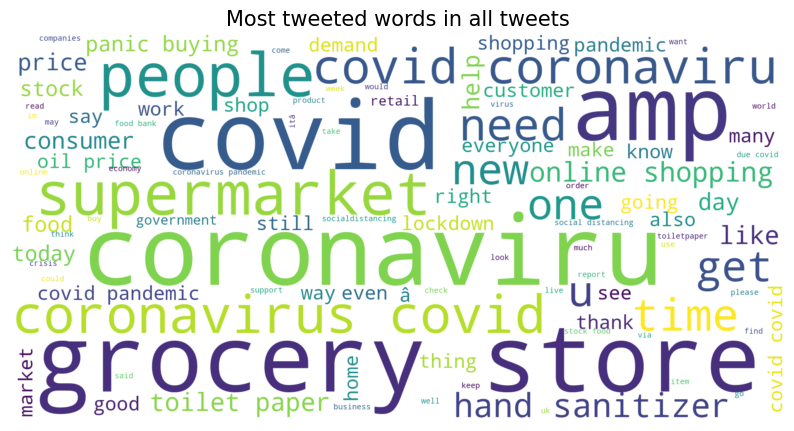

In [ ]:
tweets = ",".join(txt.lower() for txt in df_baru.OriginalTweet)

wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      stopwords=stop_words,
                      scale=5,
                      background_color="white").generate(tweets)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most tweeted words in all tweets',fontsize=15)
plt.show()

Cek panjang setiap kata

max length of word: 40
min length of word: 1


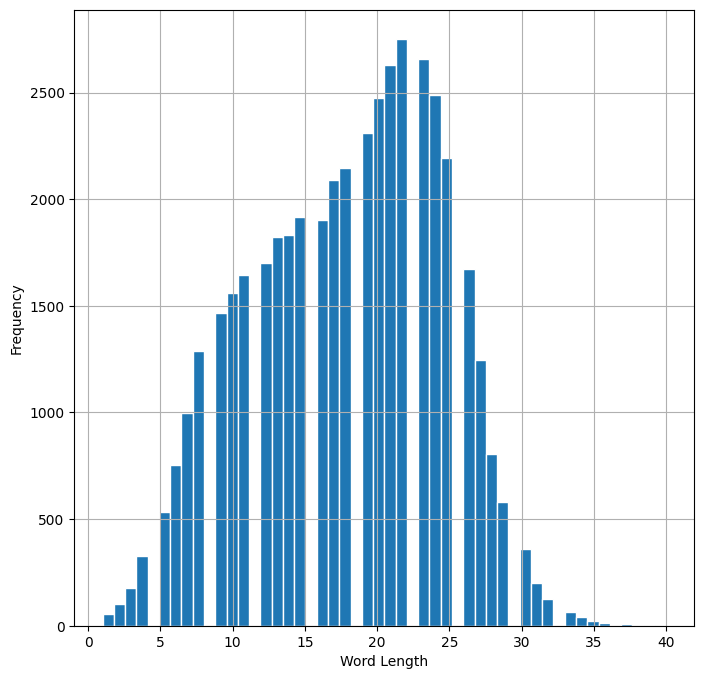

In [ ]:
length_of_words = [len(word.split(' ')) for word in df_baru.OriginalTweet]
print("max length of word:", max(length_of_words))
print("min length of word:", min(length_of_words))

plt.figure(figsize=(8, 8), num=1)
plt.hist(length_of_words, bins=50, edgecolor="white")
plt.xlabel("Word Length")
plt.ylabel("Frequency")
plt.grid()

# Input

In [ ]:
tweet = df_baru["OriginalTweet"].values
# sentimen = df_baru[["Extremely Negative",	"Extremely Positive",	"Negative",	"Neutral",	"Positive"]].values
sentimen = df_baru[["Negative",	"Neutral",	"Positive"]].values

## Set rasio to 80:20
Atur ulang rasio train dan test
*   Validation set sebesar 20% dari total dataset.



In [ ]:
tweet_train, tweet_test, sentimen_train, sentimen_test = train_test_split(tweet, sentimen, test_size=0.2)

print(tweet_train.shape, tweet_test.shape)
print(sentimen_train.shape, sentimen_test.shape)

print("train rasio: ", tweet_train.shape[0]/(tweet_train.shape[0]+tweet_test.shape[0]) * 100, "%")
print("test rasio: ", tweet_test.shape[0]/(tweet_train.shape[0]+tweet_test.shape[0]) * 100, "%")

(35964,) (8991,)
(35964, 3) (8991, 3)
train rasio:  80.0 %
test rasio:  20.0 %


## Tokenize

*   Harus menggunakan fungsi tokenizer



In [ ]:
NUM_WORDS = 5000
SEQUENCE_LENGTH = 250

tokenizer = Tokenizer(num_words=NUM_WORDS, oov_token='<oov>') # , lower=True

tokenizer.fit_on_texts(tweet_train)
# tokenizer.fit_on_texts(tweet_test)

## Sequence

In [ ]:
sequens_train = tokenizer.texts_to_sequences(tweet_train)
sequens_test = tokenizer.texts_to_sequences(tweet_test)

## Padding

In [ ]:
padded_train = pad_sequences(sequens_train, maxlen=SEQUENCE_LENGTH)
padded_test = pad_sequences(sequens_test, maxlen=SEQUENCE_LENGTH)

# Processing

## Callback
Callback akan dipanggil apabila akurasi lebih dari 90%

In [ ]:
class is90percantage(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.9 or logs.get('accuracy')>0.9):
      print(f"\n=== Akurasi telah mencapai > {logs.get('accuracy') * 100}%! ===\n")
      print(f"=== Value akurasi telah mencapai > {logs.get('val_accuracy') * 100}%! ===\n")
      self.model.stop_training = True

callbacks = is90percantage()

## Create model

*   Harus menggunakan model sequential.
*   Harus menggunakan LSTM dalam arsitektur model.
*   Harus menggunakan Embedding.



In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(NUM_WORDS, 100, input_length=padded_train.shape[1]),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.LSTM(128),
    # tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax') # jumlah kelas adalah 5
])

## Compiling

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

*   Akurasi dari model minimal 75% pada train set dan validation set.



In [ ]:
def format_seconds_to_hhmmss(seconds):
    hours = seconds // (60*60)
    seconds %= (60*60)
    minutes = seconds // 60
    seconds %= 60
    return "%02i:%02i:%02i" % (hours, minutes, seconds)

In [ ]:
start_time = time.time()

EPOCHS = 30

history = model.fit(
    padded_train,
    sentimen_train,
    epochs=EPOCHS,
    validation_data=(padded_test, sentimen_test),
    verbose=2,
    callbacks=[
        # tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.0001),
        callbacks
    ]
)

print(f"time execution: {format_seconds_to_hhmmss(time.time() - start_time)}")

Epoch 1/30
1124/1124 - 41s - loss: 0.6852 - accuracy: 0.7089 - val_loss: 0.5229 - val_accuracy: 0.8052 - 41s/epoch - 37ms/step
Epoch 2/30
1124/1124 - 16s - loss: 0.4746 - accuracy: 0.8314 - val_loss: 0.5210 - val_accuracy: 0.8111 - 16s/epoch - 14ms/step
Epoch 3/30
1124/1124 - 15s - loss: 0.4263 - accuracy: 0.8485 - val_loss: 0.5121 - val_accuracy: 0.8159 - 15s/epoch - 13ms/step
Epoch 4/30
1124/1124 - 14s - loss: 0.3859 - accuracy: 0.8619 - val_loss: 0.5422 - val_accuracy: 0.8058 - 14s/epoch - 13ms/step
Epoch 5/30
1124/1124 - 16s - loss: 0.3387 - accuracy: 0.8764 - val_loss: 0.5758 - val_accuracy: 0.8060 - 16s/epoch - 14ms/step
Epoch 6/30
1124/1124 - 14s - loss: 0.2925 - accuracy: 0.8915 - val_loss: 0.6395 - val_accuracy: 0.8046 - 14s/epoch - 13ms/step
Epoch 7/30

=== Akurasi telah mencapai > 90.67956805229187%! ===

=== Value akurasi telah mencapai > 79.90212440490723%! ===

1124/1124 - 15s - loss: 0.2521 - accuracy: 0.9068 - val_loss: 0.7185 - val_accuracy: 0.7990 - 15s/epoch - 13ms/s

# Output

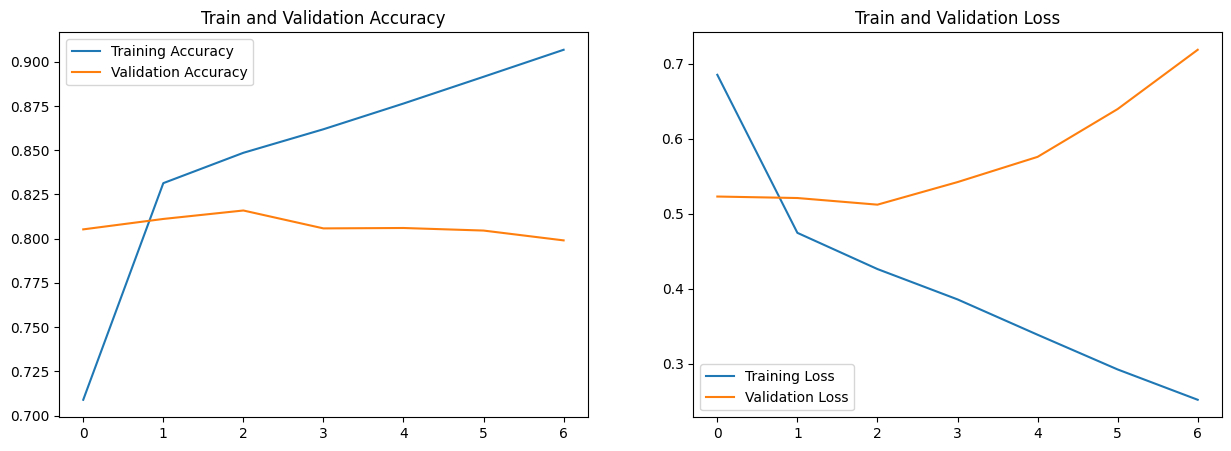

In [ ]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = history.epoch

plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Validation
validasi test set

In [ ]:
accr = model.evaluate(padded_test, sentimen_test)

print("Hasil Test:")
print(f"Loss: {accr[0]}\nAccuracy: {accr[1]}")

281/281 [==============================] - 2s 6ms/step - loss: 0.7185 - accuracy: 0.7990
Hasil Test:
Loss: 0.7185437679290771
Accuracy: 0.7990212440490723


Validasi dengan tweet



In [ ]:
classes = df["Sentiment"].value_counts()
classes = {key:value for (key, value) in enumerate(classes.keys())}

# input
tweets = [
    "Long Covid's impact raises a crucial question: How can digital health tools enhance our response to such widespread health crises? By improving remote monitoring and personalized care, we could better address the needs of millions, while also advancing preventive strategies.",
    "Millions of Americans have Long Covid. We shouldn’t forget this. To help stop the spread, high-quality masks should be freely available to everyone and required in healthcare settings. Plus we must improve indoor air quality across the country and help provide healthcare for those afflicted."
]

# processing
convert_to_array = np.array(tweets)
sequences = tokenizer.texts_to_sequences(convert_to_array)
padded = pad_sequences(sequences, maxlen=SEQUENCE_LENGTH)

# prediction
output = model.predict(padded)
for idx, result in enumerate(output):
  prob = np.round(np.max(result)*100, 2)
  cls = np.argmax(result)
  actual_label = classes[cls]

  # output
  print(tweets[idx])
  print("Probalilitas: ", prob, "%")
  print("Kelas: ", actual_label, "\n")

1/1 [==============================] - 0s 407ms/step
Long Covid's impact raises a crucial question: How can digital health tools enhance our response to such widespread health crises? By improving remote monitoring and personalized care, we could better address the needs of millions, while also advancing preventive strategies.
Probalilitas:  99.79 %
Kelas:  Neutral 

Millions of Americans have Long Covid. We shouldn’t forget this. To help stop the spread, high-quality masks should be freely available to everyone and required in healthcare settings. Plus we must improve indoor air quality across the country and help provide healthcare for those afflicted.
Probalilitas:  97.1 %
Kelas:  Neutral 

